In [1]:
from jmd_imagescraper.core import *
from jmd_imagescraper.imagecleaner import *
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

In [2]:
root = Path().cwd()/"images"
if not os.path.isdir(root):
    duckduckgo_search(root, 'sushi', '寿司', 333)
    duckduckgo_search(root, 'ramen', 'ラーメン', 333)
    duckduckgo_search(root, 'taiyaki', '鯛焼き', 333)
display_image_cleaner(root)

HTML(value='<h2>No images left to display in this folder.</h2>', layout=Layout(visibility='hidden'))

GridBox(children=(VBox(children=(Image(value=b'', layout="Layout(width='150px')"), Button(description='Delete'…

In [3]:
seed = 666

def normali(image, label):
    return image/255.,label 

def load_ds(root=root, image_size=(32,32)):
    train_ds, test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        root, label_mode='categorical', batch_size=64, image_size=image_size,
        seed=seed, validation_split=0.2, subset='both')
    return train_ds.map(normali), test_ds.map(normali), train_ds.class_names

train_ds, test_ds, class_names = load_ds()
print(class_names)

Found 946 files belonging to 3 classes.
Using 757 files for training.
Using 189 files for validation.
Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

['ramen', 'sushi', 'taiyaki']


2022-11-04 00:22:32.419345: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-04 00:22:32.419493: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Wykorzystałem tf.keras.preprocessing.image_dataset_from_dictionary(), aby wczytać dataset.  
Możemy ustawić validation split i jednocześnie wczytać oba zbiory oraz ustawić rozmiar obrazków.

2022-11-04 00:22:32.575765: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


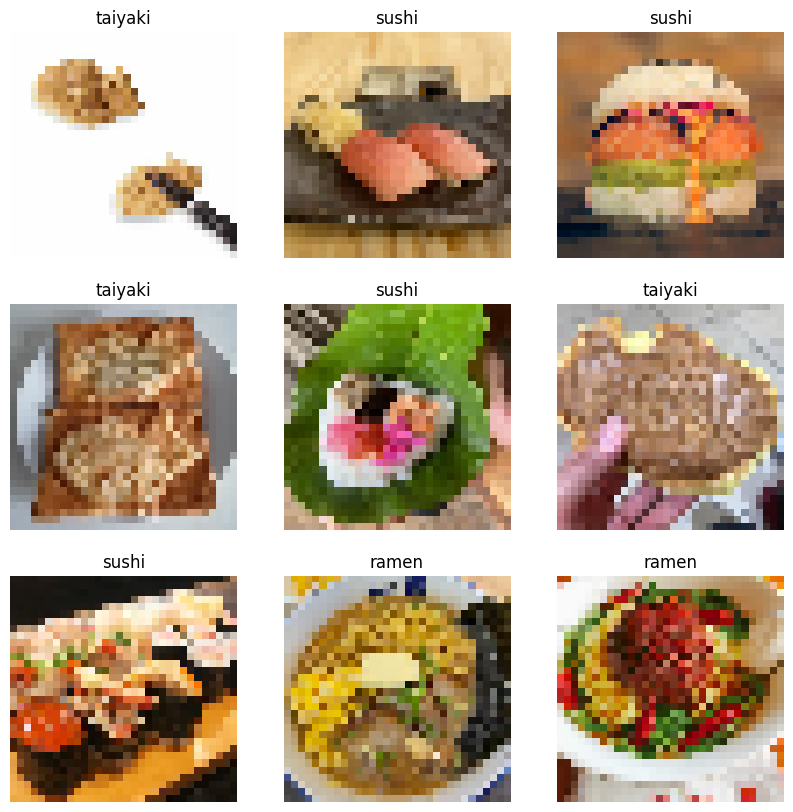

In [4]:
plt.figure(figsize=(10, 10))
for image, label in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i])
    plt.title(class_names[tf.math.argmax(label[i])])
    plt.axis("off")

# Własny model

In [5]:
def block(channels, activation='relu', input_shape=None, batch_normalisation=False, dropout=None, gap=False):
    if input_shape:
        conv1 = tf.keras.layers.Conv2D(channels, 3, padding='same', activation=activation, input_shape=input_shape)
    else:
        conv1 = tf.keras.layers.Conv2D(channels, 3, padding='same', activation=activation)
    conv2 = tf.keras.layers.Conv2D(channels, 3, padding='same', activation=activation)
    if batch_normalisation:
        batch_norm1 = tf.keras.layers.BatchNormalization()
        batch_norm2 = tf.keras.layers.BatchNormalization()
    if dropout:
        drops = tf.keras.layers.Dropout(dropout)
    if gap:
        pool = tf.keras.layers.GlobalAveragePooling2D(data_format='channels_last', keepdims=False)
    else:
        pool = tf.keras.layers.MaxPool2D(pool_size=(2,2), padding='valid')
        
    if dropout:
        return [conv1, batch_norm1, conv2, batch_norm2, pool, drops]
    elif batch_normalisation:
        return [conv1, batch_norm1, conv2, batch_norm2, pool]
    else:
        return [conv1, conv2, pool]


In [6]:
def smooth(y, window=5):
    paddedy = [y[0]]*window+y+[y[-1]]*window
    res = []
    for ix in range(len(y)):
        res.append(np.mean(y[ix:ix+2*window]))
    assert(len(y)==len(res))
    return res

def print_train_and_val(history, gtype):
    smoothy = smooth(history[gtype])
    smoothyval = smooth(history['val_'+gtype])
    plt.plot(smoothy, 'g')
    plt.plot(smoothyval, 'r')
    plt.title('Model '+gtype)
    plt.ylabel(gtype)
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

def print_history(history):
    print_train_and_val(history, 'accuracy')
    print_train_and_val(history, 'loss')


In [7]:
model = tf.keras.Sequential(
    block(channels=20, activation='relu', input_shape=(None, None, 3), batch_normalisation=True, dropout=0.1) +
    block(channels=40, activation='relu', batch_normalisation=True, dropout=0.2) + 
    block(channels=80, activation='relu', batch_normalisation=True, dropout=0.3) + 
    block(channels=160, activation='relu', batch_normalisation=True, dropout=0.4, gap=True) + [
    tf.keras.layers.Dense(units=3,activation='softmax')
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 20)    560       
                                                                 
 batch_normalization (BatchN  (None, None, None, 20)   80        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 20)    3620      
                                                                 
 batch_normalization_1 (Batc  (None, None, None, 20)   80        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 20)   0         
 )                                                               
                                                        

In [9]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [10]:
history = model.fit(
    x=train_ds,
    batch_size=64,
    epochs=150,
    verbose=1,
    validation_data=test_ds
)


Epoch 1/150


2022-11-04 00:22:34.109595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - ETA: 0s - loss: 1.1009 - accuracy: 0.3989

2022-11-04 00:22:35.275725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 2s 76ms/step - loss: 1.1009 - accuracy: 0.3989 - val_loss: 1.0966 - val_accuracy: 0.3651
Epoch 2/150
12/12 [==============================] - 0s 30ms/step - loss: 0.9707 - accuracy: 0.5099 - val_loss: 1.1015 - val_accuracy: 0.3228
Epoch 3/150
12/12 [==============================] - 0s 30ms/step - loss: 0.9113 - accuracy: 0.5720 - val_loss: 1.1100 - val_accuracy: 0.3228
Epoch 4/150
12/12 [==============================] - 0s 28ms/step - loss: 0.8068 - accuracy: 0.6341 - val_loss: 1.1160 - val_accuracy: 0.3175
Epoch 5/150
12/12 [==============================] - 0s 30ms/step - loss: 0.7908 - accuracy: 0.6552 - val_loss: 1.1298 - val_accuracy: 0.4392
Epoch 6/150
12/12 [==============================] - 0s 28ms/step - loss: 0.7474 - accuracy: 0.6962 - val_loss: 1.1573 - val_accuracy: 0.3651
Epoch 7/150
12/12 [==============================] - 0s 29ms/step - loss: 0.7239 - accuracy: 0.6922 - val_loss: 1.1767 - val_accuracy: 0.3228
Epoch 8/150
12/12 

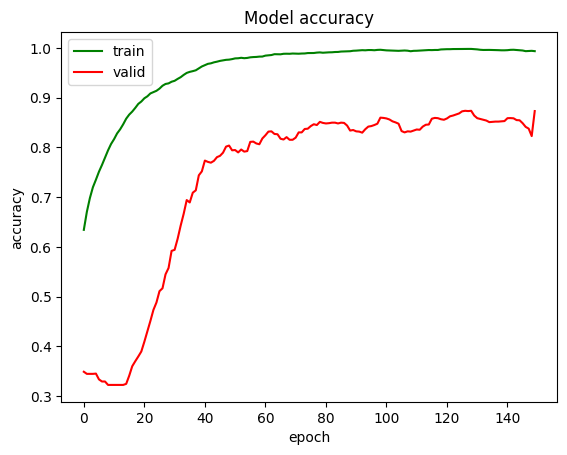

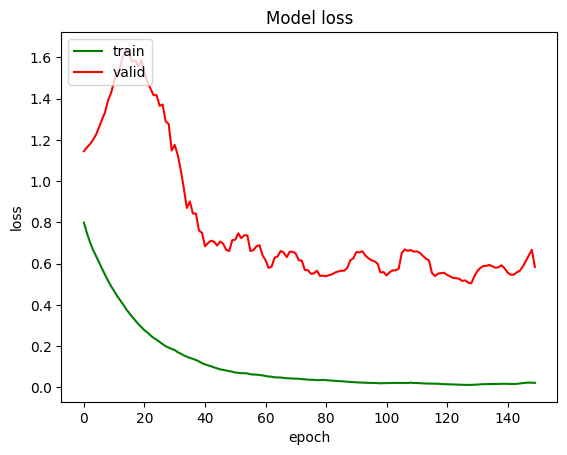

In [11]:
print_history(history.history)

Całkiem niezłe wyniki da się osiągnać, ale jednak wydaje się być trochę ograniczone małymi zbiorami danych. Szczególnie podejrzanie wyglądają duże skoki wyników na zbiorze walidacyjnym.

# Ładujemy zapisane wcześniej wagi w modelu.

In [12]:
model = tf.keras.Sequential(
    block(channels=20, activation='relu', input_shape=(None, None, 3), batch_normalisation=True, dropout=0.1) +
    block(channels=40, activation='relu', batch_normalisation=True, dropout=0.2) + 
    block(channels=80, activation='relu', batch_normalisation=True, dropout=0.3) + 
    block(channels=160, activation='relu', batch_normalisation=True, dropout=0.4, gap=True) + [
    tf.keras.layers.Dense(units=10,activation='softmax')
])

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, None, None, 20)    560       
                                                                 
 batch_normalization_8 (Batc  (None, None, None, 20)   80        
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, None, None, 20)    3620      
                                                                 
 batch_normalization_9 (Batc  (None, None, None, 20)   80        
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, None, None, 20)   0         
 2D)                                                             
                                                      

In [14]:
model.load_weights('./checkpoints/CIFAR')

In [15]:
model.trainable = False
old_model = model.layers[:-1]
old_weights = []
for layer in old_model:
    assert not layer.trainable
    old_weights.append(layer.weights)

Ustawiając parametr trainable w modelu, rekurencyjnie wszystkie warstwy mają ustawiane trainable na tą samą wartość.  
Dodatkowo korzystając z atrybutu layers mamy dostęp do warstw modelu, i w ten sposób możemy zapomnieć o ostatniej warstwie odpowiadającej za kategoryzację.

In [16]:
model = tf.keras.Sequential(old_model+[tf.keras.layers.Dense(units=3, activation='softmax')])

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, None, None, 20)    560       
                                                                 
 batch_normalization_8 (Batc  (None, None, None, 20)   80        
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, None, None, 20)    3620      
                                                                 
 batch_normalization_9 (Batc  (None, None, None, 20)   80        
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, None, None, 20)   0         
 2D)                                                             
                                                      

In [18]:
for layer in model.layers[:-1]:
    assert not layer.trainable
assert model.layers[-1].trainable

Dodałem ostatnią warstwę wyjściową z 3 kategoriami. Odpowiednio ustawiłem trainable aby upewnić się, że warstwa będzie się uczyła.

In [19]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [20]:
history = model.fit(
    x=train_ds,
    batch_size=64,
    epochs=150,
    verbose=1,
    validation_data=test_ds
)


Epoch 1/150


2022-11-04 00:23:50.661299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 1s 49ms/step - loss: 1.3532 - accuracy: 0.3197 - val_loss: 1.2619 - val_accuracy: 0.3386


2022-11-04 00:23:51.307950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 2/150
12/12 [==============================] - 0s 23ms/step - loss: 1.3014 - accuracy: 0.3184 - val_loss: 1.1909 - val_accuracy: 0.3545
Epoch 3/150
12/12 [==============================] - 0s 23ms/step - loss: 1.2639 - accuracy: 0.3382 - val_loss: 1.1372 - val_accuracy: 0.3598
Epoch 4/150
12/12 [==============================] - 0s 24ms/step - loss: 1.1526 - accuracy: 0.3765 - val_loss: 1.1013 - val_accuracy: 0.3757
Epoch 5/150
12/12 [==============================] - 0s 23ms/step - loss: 1.1809 - accuracy: 0.3712 - val_loss: 1.0741 - val_accuracy: 0.3810
Epoch 6/150
12/12 [==============================] - 0s 20ms/step - loss: 1.0958 - accuracy: 0.4069 - val_loss: 1.0501 - val_accuracy: 0.4286
Epoch 7/150
12/12 [==============================] - 0s 20ms/step - loss: 1.0892 - accuracy: 0.4597 - val_loss: 1.0317 - val_accuracy: 0.4444
Epoch 8/150
12/12 [==============================] - 0s 24ms/step - loss: 1.0416 - accuracy: 0.4597 - val_loss: 1.0135 - val_accuracy: 0.4656
Epoch 

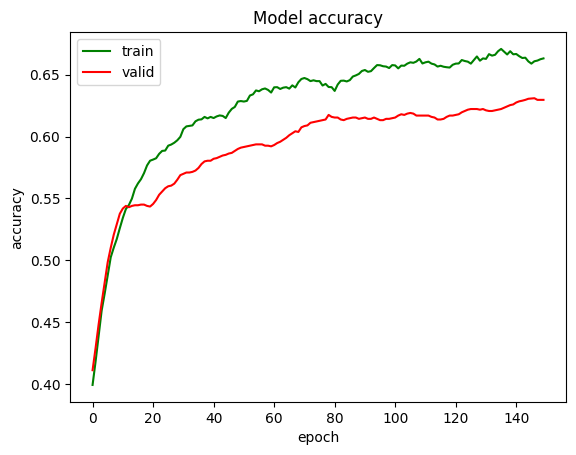

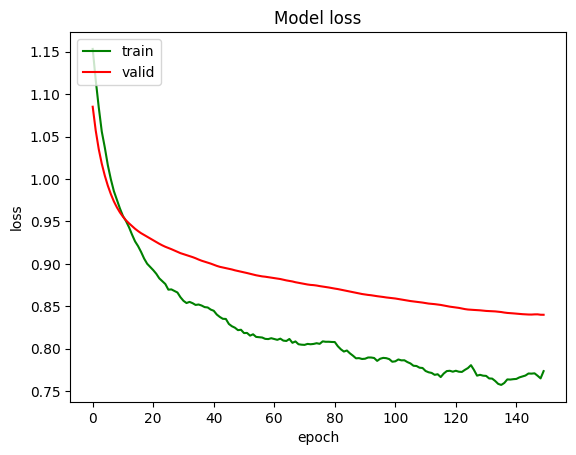

In [21]:
print_history(history.history)

In [22]:
for ix in range(len(model.layers[:-1])):
    assert model.layers[ix].weights == old_weights[ix]

Jak widać model zachowuje się tak jak powinien - tylko ostatnia warstwa zmienia wagi.  
Niestety wyniki są poniżej oczekiwań, szczególnie w porównaniu do trenowania modelu od zera.  
Możliwe, że mógłbym dobrać lepsze parametry, np. learning rate, liczbę epok, czy momentum.

# ImageNet

In [23]:
train_ds, test_ds, _ = load_ds(image_size=(256,256))

Found 946 files belonging to 3 classes.
Using 757 files for training.
Using 189 files for validation.


In [24]:
model = tf.keras.applications.xception.Xception(
    include_top=False,
    input_shape=(256,256,3),
    # pooling='avg',
    classifier_activation='softmax'
)


In [25]:
model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [26]:
print(len(model.layers), model.layers[-1])

132 <keras.layers.core.activation.Activation object at 0x2cab0b9a0>


In [27]:
model.trainable = False
for layer in model.layers:
    assert not layer.trainable

In [28]:
model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

Model jest dopasowany do wejścia 256x256x3, dodatkowo wszystko powyżej GAP jest usunięte oraz warstwy zamrożone.

In [29]:
base_model = model
output = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(units=3, activation='softmax')(output)
model = tf.keras.Model(base_model.input, output)

In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

Stworzyłem nowy model, który składa się z modelu xception, GAP i warstwy wyjściowej.  

In [32]:
for layer in model.layers[:-2]:
    assert not layer.trainable
assert model.layers[-2].trainable
assert model.layers[-1].trainable

In [33]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [34]:
history = model.fit(
    x=train_ds,
    batch_size=64,
    epochs=30,
    verbose=1,
    validation_data=test_ds
)


Epoch 1/30


2022-11-04 00:28:57.022150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - ETA: 0s - loss: 1.0921 - accuracy: 0.3910

2022-11-04 00:29:04.254271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 11s 793ms/step - loss: 1.0921 - accuracy: 0.3910 - val_loss: 0.8689 - val_accuracy: 0.7037
Epoch 2/30
12/12 [==============================] - 9s 748ms/step - loss: 0.6989 - accuracy: 0.8230 - val_loss: 0.5309 - val_accuracy: 0.9312
Epoch 3/30
12/12 [==============================] - 9s 707ms/step - loss: 0.4407 - accuracy: 0.9498 - val_loss: 0.3696 - val_accuracy: 0.9683
Epoch 4/30
12/12 [==============================] - 9s 710ms/step - loss: 0.3199 - accuracy: 0.9617 - val_loss: 0.2901 - val_accuracy: 0.9841
Epoch 5/30
12/12 [==============================] - 8s 642ms/step - loss: 0.2577 - accuracy: 0.9696 - val_loss: 0.2441 - val_accuracy: 0.9841
Epoch 6/30
12/12 [==============================] - 8s 640ms/step - loss: 0.2207 - accuracy: 0.9749 - val_loss: 0.2149 - val_accuracy: 0.9841
Epoch 7/30
12/12 [==============================] - 8s 642ms/step - loss: 0.1962 - accuracy: 0.9762 - val_loss: 0.1949 - val_accuracy: 0.9841
Epoch 8/30
12/12

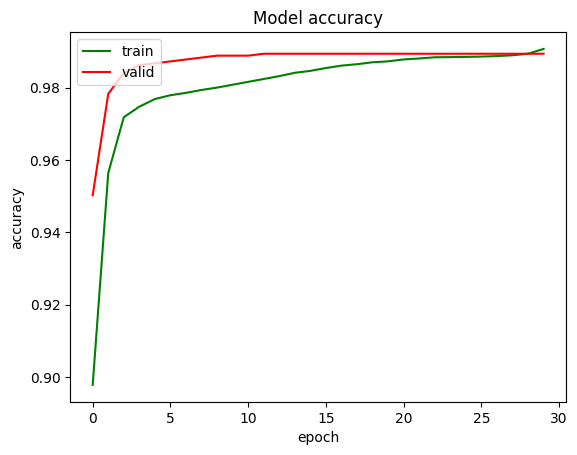

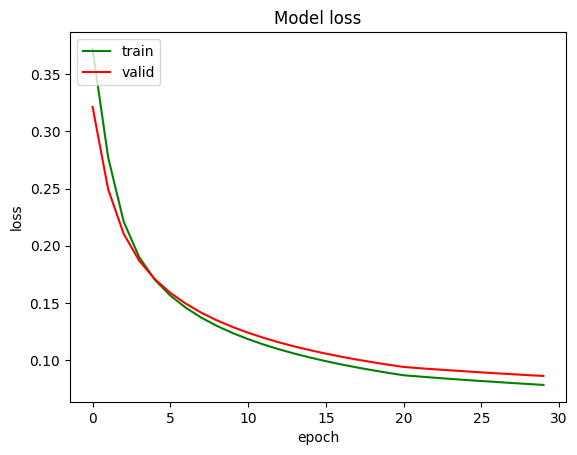

In [35]:
print_history(history.history)

In [36]:
model.save_weights('./checkpoints/imagenet')

Tym razem otrzymaliśmy naprawdę łądne wyniki, co nie jest zaskakujące biorąc pod uwagę jak mocny model wykorzystujemy.  
Co ciekawe accuracy na zbiorze walidacyjnym przez spory czas wychodziło większe niż na zbiorze treningowym.

In [37]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

### Fine-tuning

In [39]:
model.trainable=True
for layer in model.layers:
    if type(layer) == tf.keras.layers.BatchNormalization:
        layer.trainable=False
    else:
        layer.trainable=True
    assert (type(layer) == tf.keras.layers.BatchNormalization) != layer.trainable
print(sum([type(layer) == tf.keras.layers.BatchNormalization for layer in model.layers]))
model.summary()

40
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

Rozmroziłem wszystkie warstwy, poza tf.keras.layers.BatchNormalization.  
Ustawienie batchnormalization.training na False, właśnie wprowadza normalizację w taki pośredni stan jak opisany w treści zadania.

In [40]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [41]:
history = model.fit(
    x=train_ds,
    batch_size=64,
    epochs=30,
    verbose=1,
    validation_data=test_ds
)


Epoch 1/30


2022-11-04 00:41:10.965528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - ETA: 0s - loss: 0.0765 - accuracy: 0.9908

2022-11-04 00:41:32.677847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 25s 2s/step - loss: 0.0765 - accuracy: 0.9908 - val_loss: 0.0829 - val_accuracy: 0.9894
Epoch 2/30
12/12 [==============================] - 22s 2s/step - loss: 0.0721 - accuracy: 0.9908 - val_loss: 0.0778 - val_accuracy: 0.9894
Epoch 3/30
12/12 [==============================] - 21s 2s/step - loss: 0.0667 - accuracy: 0.9921 - val_loss: 0.0728 - val_accuracy: 0.9894
Epoch 4/30
12/12 [==============================] - 21s 2s/step - loss: 0.0617 - accuracy: 0.9934 - val_loss: 0.0689 - val_accuracy: 0.9894
Epoch 5/30
12/12 [==============================] - 21s 2s/step - loss: 0.0573 - accuracy: 0.9934 - val_loss: 0.0654 - val_accuracy: 0.9894
Epoch 6/30
12/12 [==============================] - 21s 2s/step - loss: 0.0535 - accuracy: 0.9934 - val_loss: 0.0623 - val_accuracy: 0.9894
Epoch 7/30
12/12 [==============================] - 21s 2s/step - loss: 0.0500 - accuracy: 0.9947 - val_loss: 0.0597 - val_accuracy: 0.9894
Epoch 8/30
12/12 [=============

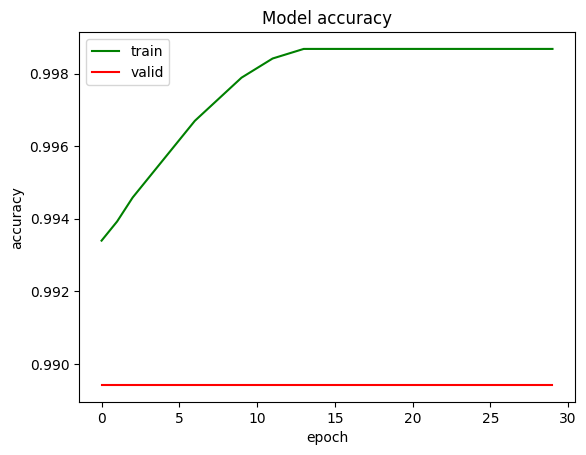

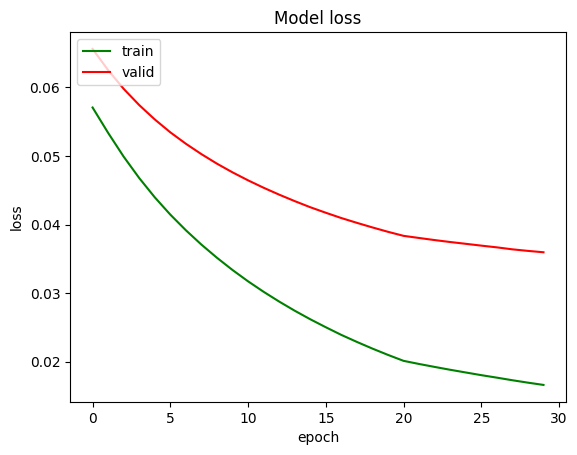

In [42]:
print_history(history.history)

In [43]:
model.save_weights('./checkpoints/imagenet_finetuning')
model.save('./saved_model/imagenet_finetuning')

INFO:tensorflow:Assets written to: ./saved_model/imagenet_finetuning/assets


INFO:tensorflow:Assets written to: ./saved_model/imagenet_finetuning/assets


Na tak przygotowanym modelu, udało się osiągnąć na prawdę dobry wynik.  
Jak widać fine tuning bardzo dobrze się sprawdza w takich sytuacjach.  
Otrzymujemy bardzo dobre accuracy i stale zmniejszamy loss.  
Co ciekawe, accuracy na zbiorze walidacyjnym się nie zmienia, ale myślę, że wynika to z małego rozmiaru zbioru walidacyjnego oraz jakiegoś bardzo trudnego zdjęcia.

# Decyzje?

In [44]:
def get_5_each():
    res = [[],[],[]]
    for img, label in test_ds:
        print(tf.math.argmax(label, axis=1))
        res[0] = img[tf.math.argmax(label, axis=1)==0][:5]
        res[1] = img[tf.math.argmax(label, axis=1)==1][:5]
        res[2] = img[tf.math.argmax(label, axis=1)==2][:5]
        return res

fives = get_5_each()

tf.Tensor(
[1 0 0 1 1 2 0 1 1 0 1 0 0 1 1 0 2 1 0 2 2 0 0 0 2 1 2 0 2 0 1 1 1 0 2 2 2
 1 1 2 0 1 1 2 0 0 0 2 1 0 1 2 0 1 1 1 1 1 0 1 2 0 2 2], shape=(64,), dtype=int64)


In [45]:
print(len(fives), len(fives[0]), len(fives[1]), len(fives[2]), tf.expand_dims(fives[0][1].shape, 0))

3 5 5 5 tf.Tensor([[256 256   3]], shape=(1, 3), dtype=int32)


Niestety mam straszne trudności zarządzać tym datasetem - stąd funkcja get_5_each

In [46]:
for ix, cat in enumerate(fives):
    for img in cat:
        assert (tf.math.argmax(model.predict(tf.expand_dims(img,0)), axis=1)==ix)

2022-11-04 01:00:01.988475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 22ms/step


Upewniłem się, że model poprawnie zgaduje te zdjęcia.

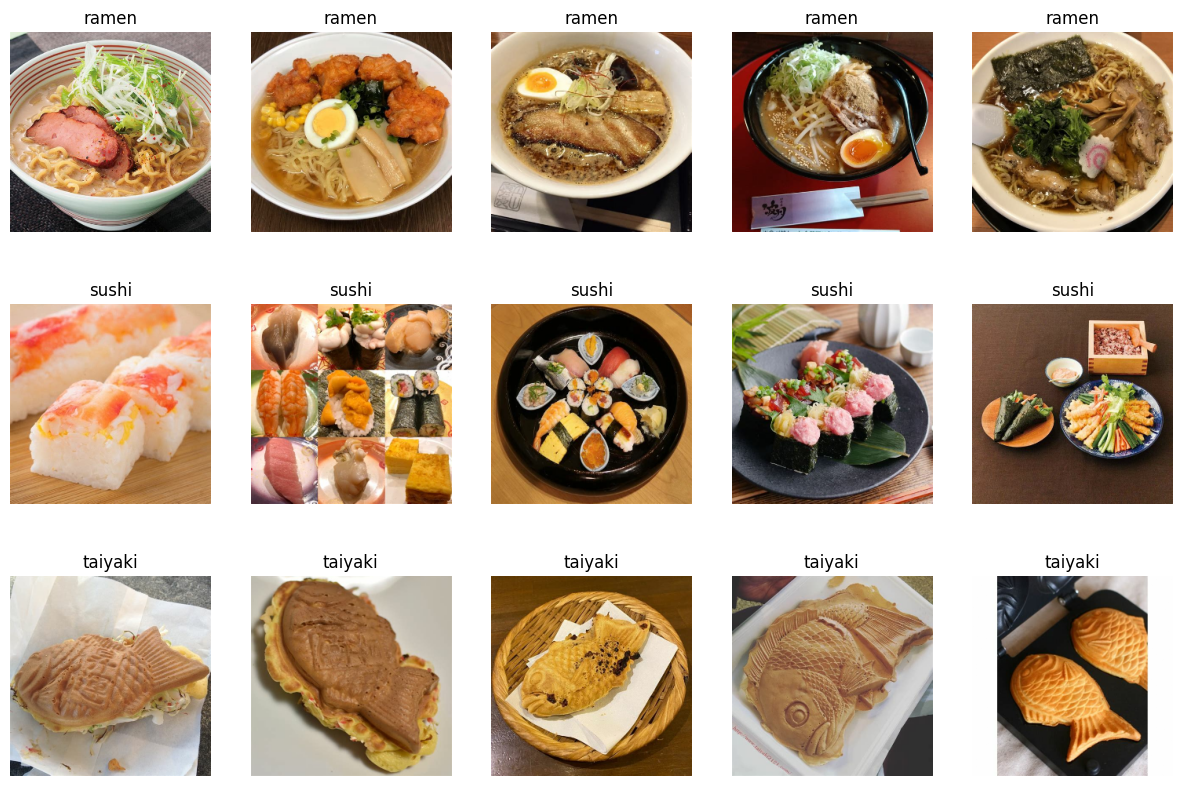

In [47]:
plt.figure(figsize=(15, 10))
for ix, cat in enumerate(fives):
  for ixx, img in enumerate(cat):
    ax = plt.subplot(3, 5, ixx + 1 + ix*5)
    plt.imshow(img)
    plt.title(class_names[ix])
    plt.axis("off")
    plt.yticks([])
  plt.xticks([])

In [48]:
model.predict(tf.expand_dims(fives[0][0], 0))

1/1 [==============================] - 0s 26ms/step


array([[9.9987638e-01, 8.8199653e-05, 3.5363988e-05]], dtype=float32)

In [50]:
model.layers[-5:], model.layers[-3]

([<keras.layers.convolutional.separable_conv2d.SeparableConv2D at 0x2cab0bdc0>,
 <keras.layers.core.activation.Activation at 0x2cab0b9a0>)

In [51]:
tmp_model = tf.keras.models.Model(inputs=model.input,outputs=model.layers[-3].output)

In [54]:
tmp_model.output_shape

(None, 8, 8, 2048)

In [57]:
res = tmp_model.predict(tf.expand_dims(fives[0][0], 0))

1/1 [==============================] - 0s 28ms/step


742


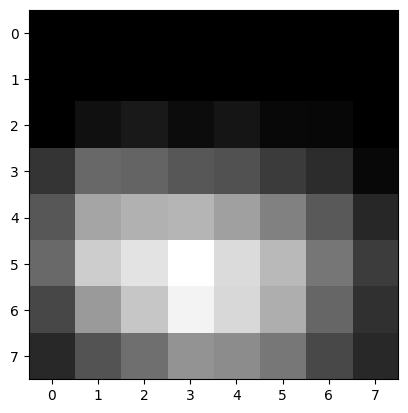

1973


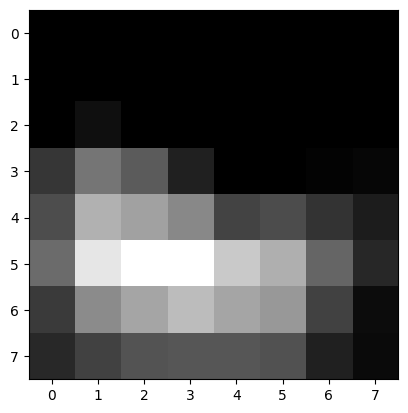

845


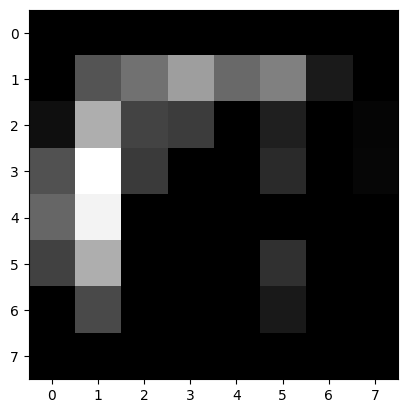

763


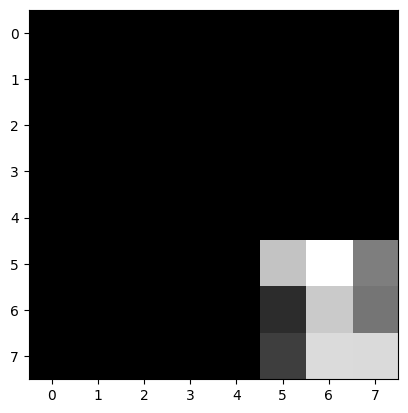

469


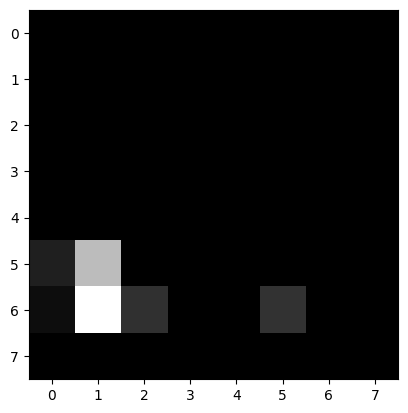

In [64]:
def print_gray(img):
    plt.imshow(img, cmap='gray')
    plt.show()

res[0,:,:,1].shape
for channel in np.random.randint(0, 2048, 5):
    print(channel)
    print_gray(res[0,:,:,channel])

Interesujące, ale ciężko coś na ten temat powiedzieć.  
Trochę za dużo kanałów aby pojąć.  
Możemy natomiast zrozumieć jakie fragmenty obrazka jak duży miały wpływ na poszczególne kanały wynikowe.

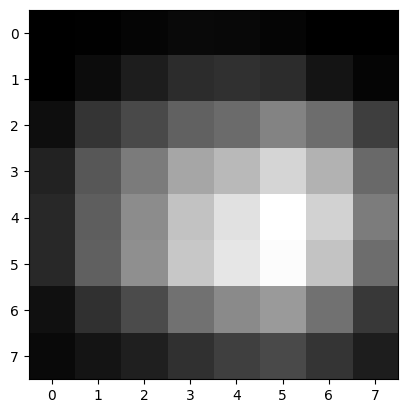

In [139]:
def get_heat(x, weights, cat):
    return tf.math.reduce_sum(x * weights[:,cat], axis=2)

def show_heatmap(x, weights, cat):
    res = get_heat(x, weights, cat)
    print_gray(res)

show_heatmap(res[0], model.layers[-1].get_weights()[0], 0)

Do wykonania zadania wykorzystałem operacje na tensorach oraz tf.math.reduce.sum().  

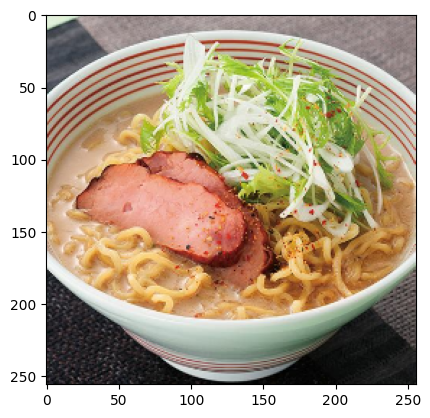

In [119]:
def print_image(img):
    plt.imshow(img)
    plt.show()

print_image(fives[0][0])

Wygląda na to, że nasza heatmapa bardzo słusznie skupiła się na misce z ramenem, w szczególności zawartości ramenu.  
Ma to zaskakująco dużo sensu.

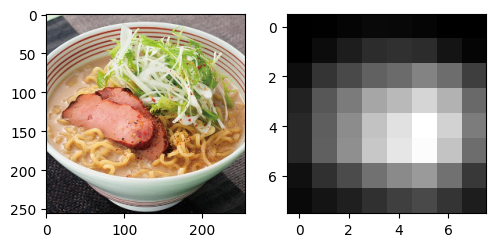

In [137]:
def print_both(img, heat):
    plt.figure(figsize=(15, 15))
    plt.subplot(5,5,1)
    plt.imshow(img)
    plt.subplot(5,5,2)
    plt.imshow(heat, cmap='gray')
    plt.show()

print_both(fives[0][0], get_heat(res[0], model.layers[-1].get_weights()[0]))

1/1 [==============================] - 0s 63ms/step


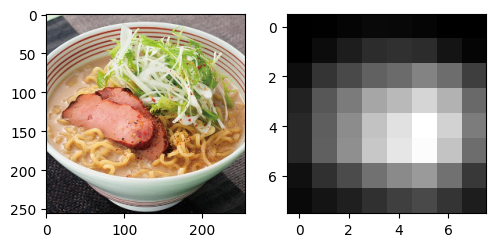

1/1 [==============================] - 0s 99ms/step


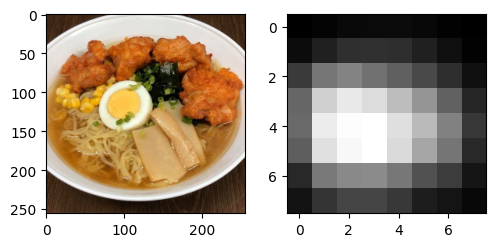

1/1 [==============================] - 0s 24ms/step


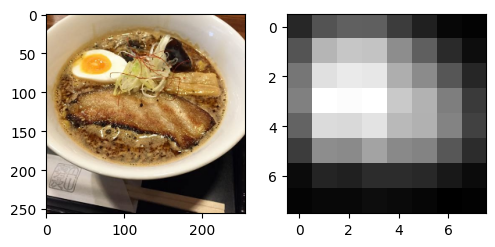

1/1 [==============================] - 0s 23ms/step


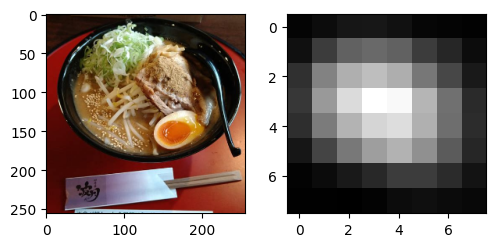

1/1 [==============================] - 0s 23ms/step


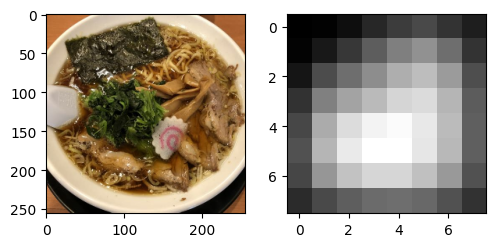

1/1 [==============================] - 0s 23ms/step


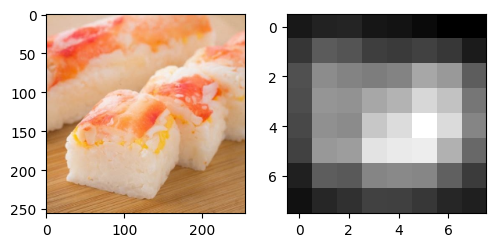

1/1 [==============================] - 0s 24ms/step


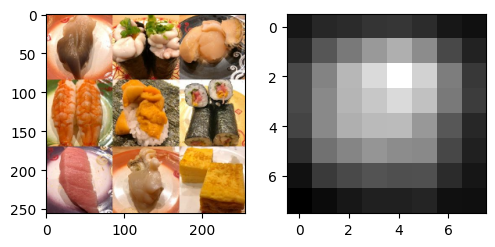

1/1 [==============================] - 0s 25ms/step


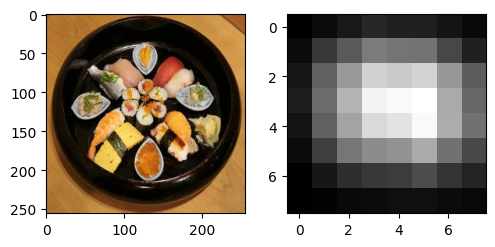

1/1 [==============================] - 0s 23ms/step


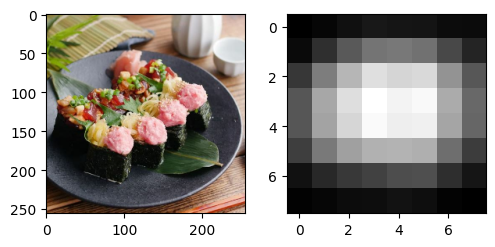

1/1 [==============================] - 0s 24ms/step


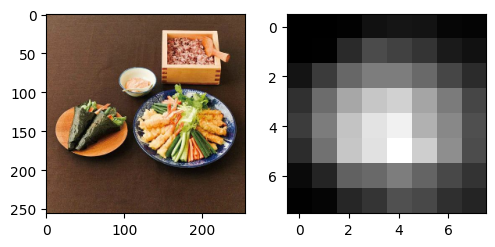

1/1 [==============================] - 0s 29ms/step


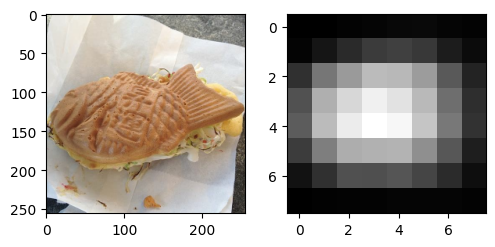

1/1 [==============================] - 0s 22ms/step


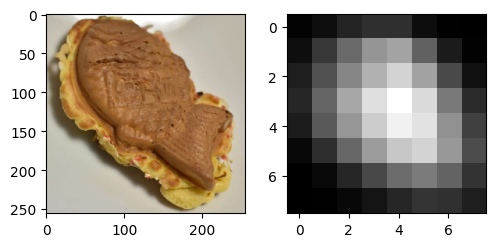

1/1 [==============================] - 0s 22ms/step


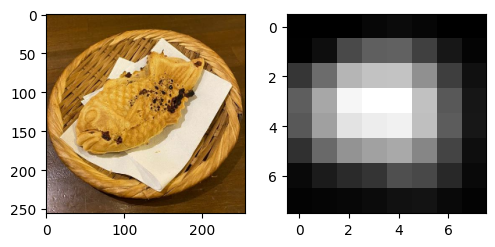

1/1 [==============================] - 0s 24ms/step


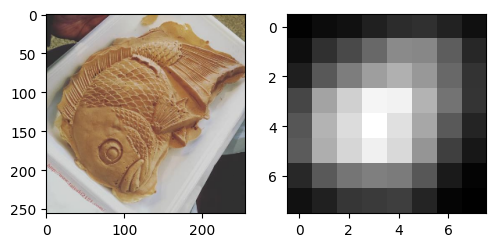

1/1 [==============================] - 0s 23ms/step


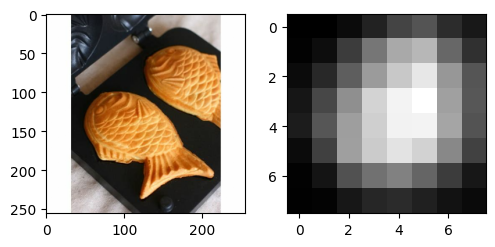

In [196]:
def compare_heats(model, tmp_model, img, cat):
    print_both(img,
        get_heat(tmp_model.predict(tf.expand_dims(img, 0))[0], model.layers[-1].get_weights()[0], cat))


for cat, five in enumerate(fives):
    for img in five:
        compare_heats(model=model, tmp_model=tmp_model, img=img, cat=cat)

Bardzo ciekawe wyniki.  
Wygląda na to, że każda kategoria jest bardzo słusznie rozpoznawana, po rzecywiście istotnych cechach (cechach jedzenia, a nie np. talerzy etc.).  
Nawet podchwytliwe zdjęcie zawierające kompilację kilku zdjęć z sushi wypadło całkiem nieźle, choć zdecydowanie najgorzej ze wszystkich i jest to moim zdaniem zrozumiałe.

In [195]:
wrongs = []

for images, labels in train_ds:
    bools = tf.math.argmax(labels,axis=1) != tf.math.argmax(model.predict(images), axis=1)
    wrongs += list(zip(images[bools], labels[bools]))

for images, labels in test_ds:
    bools = tf.math.argmax(labels,axis=1) != tf.math.argmax(model.predict(images), axis=1)
    wrongs += list(zip(images[bools], labels[bools]))

print(len(wrongs))

2/2 [==============================] - 1s 881ms/step
3


Wydaje mi się, żę dataset shuffluje batche, dlatego niestety postaram się tę część zrobić bardziej interacyjnie...  
Na małym zbiorze danych nie powinno to być dużym problemem.

In [197]:
def print_4(img, heat1, heat2, heat3):
    plt.figure(figsize=(15, 15))
    plt.subplot(5,5,1)
    plt.imshow(img)
    plt.subplot(5,5,2)
    plt.imshow(heat1, cmap='gray')
    plt.subplot(5,5,3)
    plt.imshow(heat2, cmap='gray')
    plt.subplot(5,5,4)
    plt.imshow(heat3, cmap='gray')
    plt.show()


1/1 [==============================] - 0s 25ms/step
Expected=sushi			Predicted=ramen			[0.6697369  0.29162917 0.03863393]


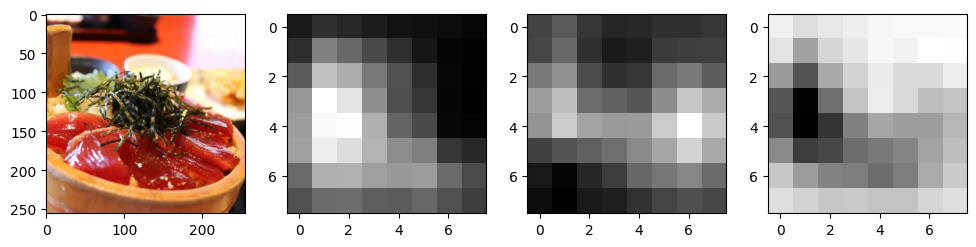

1/1 [==============================] - 0s 25ms/step
Expected=ramen			Predicted=sushi			[0.3538958  0.45931664 0.18678764]


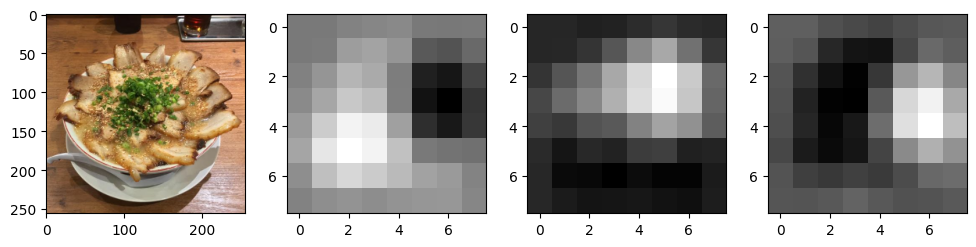

1/1 [==============================] - 0s 25ms/step
Expected=sushi			Predicted=taiyaki			[0.16951361 0.36088547 0.46960092]


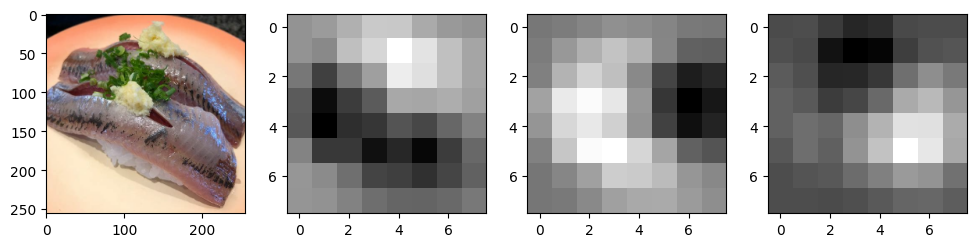

In [210]:
for image, label in wrongs:
    res = tmp_model.predict(tf.expand_dims(image, 0))[0]
    pred = model.predict(tf.expand_dims(image, 0))[0]
    print(f"Expected={class_names[tf.math.argmax(label)]}\t\t\tPredicted={class_names[tf.math.argmax(pred)]}\t\t\t{pred}")
    print_4(image,
        get_heat(res, model.layers[-1].get_weights()[0], 0),
        get_heat(res, model.layers[-1].get_weights()[0], 1),
        get_heat(res, model.layers[-1].get_weights()[0], 2))

Myślę, że pomijając drugi obrazek, przedstawiający ramen, w którym niewiele widać, pierwszy i trzeci człowiek by dobrze sklasyfikował.  
Spośród 3 kategori, nawet z drugim obrazkiem człowiek by sobie poradził.  
Z pewnością nie są to natomiast bardzo typowe elementy klasy (żaden z nich nie jest bardzo typowy, prawdopodobnie najbardziej typowy jest trzeci).  
Jak widać, model nie ma dużej pewności co do żadnej klasy, aczkolwiek zazwyczaj ma widocznie klasę do której obrazek nie należy.  
Po analizie heatmap, możemy stwierdzić, że model widzi różne cechy różnych klas i żadna nie wybija się znacząco ponad pozostałe klasy.  
Ciężko mi coś więcej wywnioskować.